In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as fn
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

Using: cuda


In [53]:
class MnistModel(nn.Module):
    def __init__(self, layers, units):
        super().__init__()

        self.layers = layers
        self.units = units

        self.input = nn.Linear(784, units)
        self.hidden = nn.ModuleList([nn.Linear(units, units) for _ in range(layers)])
        self.output = nn.Linear(units, 10)

    def forward(self, x):
        x = fn.relu(self.input(x))

        for i in range(self.layers):
            x = fn.relu(self.hidden[i](x))

        return self.output(x)

In [54]:
def create_data(batch_size):
    data = np.loadtxt(open("../../datasets/mnist_train_small.csv", "rb"), delimiter=",")

    labels = data[:, 0]
    data = MinMaxScaler().fit_transform(data[:, 1:])

    data_tensor = torch.tensor(data).float()
    labels_tensor = torch.tensor(labels).long()

    train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.1,
                                                                        shuffle=True)

    train_data = TensorDataset(train_data, train_labels)
    test_data = TensorDataset(test_data, test_labels)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

    return train_loader, test_loader

In [55]:
def create_model(layers, units, learning_rate):
    model = MnistModel(layers, units)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    return model, loss_fn, optimizer

In [56]:
def train_model(model, loss_fn, optimizer, train_loader, test_loader, epochs):
    train_acc = torch.zeros(epochs).to(device)
    test_acc = torch.zeros(epochs).to(device)

    for idx_epoch in range(epochs):
        model.train()

        batch_acc = torch.zeros(len(train_loader)).to(device)

        for idx_batch, (x, y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)

            output = model(x)
            loss = loss_fn(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            matches = torch.argmax(output, dim=1) == y
            matches_float = matches.float()
            accuracy = 100 * torch.mean(matches_float)
            batch_acc[idx_batch] = accuracy

        train_acc[idx_epoch] = torch.mean(batch_acc)

        model.eval()
        x, y = next(iter(test_loader))
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            output = model(x)

        matches = torch.argmax(output, dim=1) == y
        matches_float = matches.float()
        accuracy = 100 * torch.mean(matches_float)
        test_acc[idx_epoch] = accuracy

    return train_acc, test_acc

In [73]:
def run_the_experiment(epochs, batch_size, learning_rate):
    layers_list = [n for n in range(1, 4)]
    units_list = [n for n in range(50, 251, 50)]

    train_acc = torch.zeros((len(layers_list), len(units_list), epochs)).to(device)
    test_acc = torch.zeros((len(layers_list), len(units_list), epochs)).to(device)

    train_loader, test_loader = create_data(batch_size)

    for idx_layers, layers in enumerate(layers_list):
        for idx_units, units in enumerate(units_list):
            model, loss_fn, optimizer = create_model(layers, units, learning_rate)
            model = model.to(device)
            loss_fn = loss_fn.to(device)

            tmp_train_acc, tmp_test_acc = train_model(model, loss_fn, optimizer, train_loader, test_loader, epochs)

            train_acc[idx_layers, idx_units] = tmp_train_acc
            test_acc[idx_layers, idx_units] = tmp_test_acc

            print(f"Layers: {layers}, Units: {units} - done!")

    return train_acc, test_acc, units_list, layers_list

In [74]:
train_acc, test_acc, units_list, layers_list = run_the_experiment(50, 32, .01)

Layers: 1, Units: 50 - done!
Layers: 1, Units: 100 - done!
Layers: 1, Units: 150 - done!
Layers: 1, Units: 200 - done!
Layers: 1, Units: 250 - done!
Layers: 2, Units: 50 - done!
Layers: 2, Units: 100 - done!
Layers: 2, Units: 150 - done!
Layers: 2, Units: 200 - done!
Layers: 2, Units: 250 - done!
Layers: 3, Units: 50 - done!
Layers: 3, Units: 100 - done!
Layers: 3, Units: 150 - done!
Layers: 3, Units: 200 - done!
Layers: 3, Units: 250 - done!


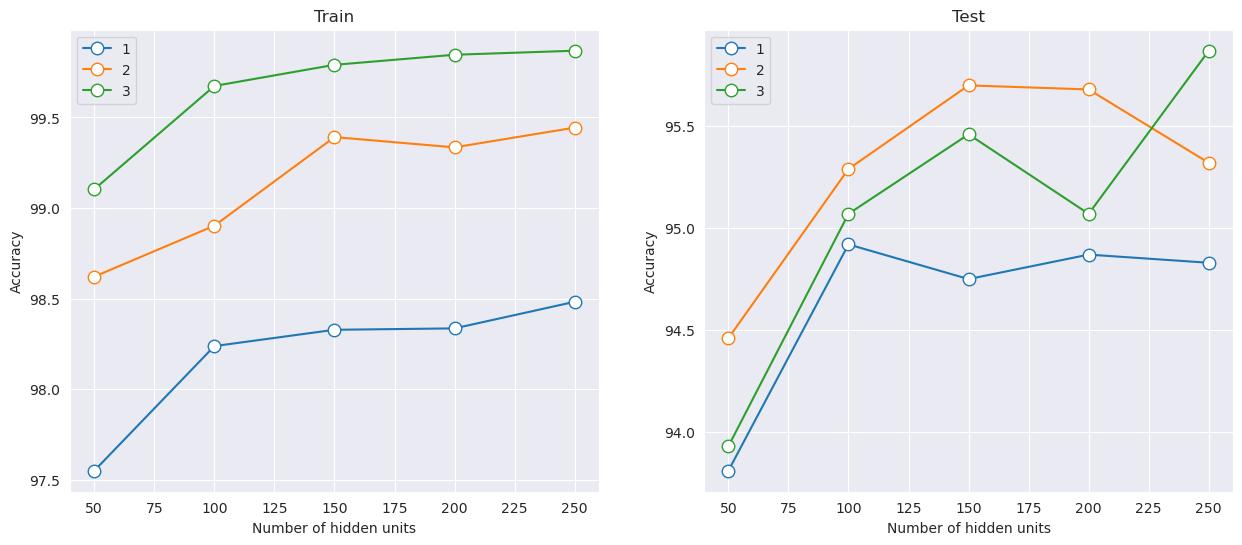

In [78]:
mean_last_5_train_acc = train_acc[:, :, -5:].mean(dim=2).cpu().numpy()
mean_last_5_test_acc = test_acc[:, :, -5:].mean(dim=2).cpu().numpy()

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

for i in range(mean_last_5_train_acc.shape[0]):
    ax[0].plot(units_list, mean_last_5_train_acc[i, :], 'o-', markerfacecolor='w', markersize=9)

for i in range(mean_last_5_test_acc.shape[0]):
    ax[1].plot(units_list, mean_last_5_test_acc[i, :], 'o-', markerfacecolor='w', markersize=9)

for i in range(2):
    ax[i].legend(layers_list)
    ax[i].set_ylabel('Accuracy')
    ax[i].set_xlabel('Number of hidden units')
    ax[i].set_title(['Train' if i == 0 else 'Test'][0])

plt.show()

In [77]:
mean_last_5_test_acc

array([[93.81001 , 94.920006, 94.750015, 94.87001 , 94.83001 ],
       [94.460014, 95.29001 , 95.700005, 95.68001 , 95.32001 ],
       [93.93001 , 95.07001 , 95.460014, 95.07001 , 95.87    ]],
      dtype=float32)